# Module 4

# Step 2: Sensitivity Analysis

# Summary.

I ran one-at-a-time (OAT) parameter testing before switching over to more direct Sobel Sensitivity Analysis.

Using the model currency of "altruists" (count of surviving altruists after an arbitrary number of ticks), the parameter the model shows most sensitivity to is by far `cost_of_altruism`, followed distantly from `benefit_of_altruism`. There is a non-trivial second order interaction between the two when evaluating the altruists currency alone, and in fact the total impact of `benefit_of_altruism` (ST) seems largely contributed by its relationship with `cost_of_altruism`.

Using the model currency of "selfish" (count of surviving selfish after an arbitrary number of ticks), `cost_of_altruism` is still dominant, but the model effects of `harshness` and `disease` are more significant with this currency (more so with `harshness` in particular). Again there is a strong second order relationship between `cost_of_altruism` and `benefit_of_altruism`, and there is also a relatively weak second order connection between `harshness` and `disease` when the currency "selfish" is considered. Finally, "ST" values are stronger in general for the "selfish" currency with respect to the first and second order measures, so we might say this currency is a but more "swampy" than the altruists outcomes of the model. There may be some significant three-parameter effects we are not testing for. 

All analysis values are listed in the notebook below.

The alternate ("less stochastic") model is studied as well, but shows only inconclusive differences in first and second order variable relationships.

Generally speaking, I tried to use significantly large run counts simply because I did not know the model well. For the Sobel Analyses, I selected run counts (in the Sobel Problems) by simply mirroring the documented defaults.

One note: I was a bit surprised by some of these conclusions. I expect larger first and second order effects from `disease`, `harshness`, and `disease - harshness`. I re-ran everything (20480 runs of headless NetLogo!) and my results are essentially stable, so unless I have some systemic error, the results seem somewhat conclusive. 


# Introduction

For this section, we will refer primarily to methods indicated in Ligmann-Zielinska et al. (2020) (LZ 2020), Kwakkel (2017), and course materials.[^1][^2]

As we mention in the previous section, the Altruism model is a more "abstract" model. Therefore, it seems that an appropriate route for sensitivity analysis (SA) would be to start with a One at A Time (OAT) SA, as recommended by Figure 3 in LZ 2020. Note that here we have selected a simpler OAT rather than an One Factor At a Time--we are stepping through all of the parameters at regular intevals (see in the ranges below) rather than using random intervals. We do this with the intent to better understand the model and choose a next analysis.



In [2]:
import os
import sys
import numpy as np
import pandas as pd

from SALib.sample import sobol as sobolsample
from SALib.analyze import sobol

# Add the parent directory to the Python path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from utils.pynetlogo_utils import run_altruism_experiment, run_altruism_experiment_sobol, process_results, load_sobel_results


base_altruism_model = "./M4Model_Dresslar_base.nlogo"  # (copied into this directory!)
alt_altruism_model = "./M4Model_Dresslar_modified.nlogo"

max_ticks = 15000  # so expensive. many runs collapse right away, but if they do not we need to know why.

# important: run_altruism_experiment needs arrays even if we have single value params, which we do.
# keep the first two params at 0.26
altruistic_probability = [0.26]
selfish_probability = [0.26]

# four ranges, one for each sensitivity param
cost_range = np.linspace(0, 1.0, 5) # note that > 0.9 is OOB
benefit_range = np.linspace(0, 1.0, 5) # note that > 0.9 is OOB
disease_range = np.linspace(0, 1.0, 5) # inclusive of 1.0
harshness_range = np.linspace(0, 1.0, 5) # inclusive of 1.0
runs_per_node = 10

As requested in the assignment, we are exploring the (altruism) cost, (altruism) benefit, disease, and harshness parameters of the model. Our currency is the populations of "altruists" and "selfish" at the completion of the model. We might note that a specific model behavior is the collapse and extinction of one of the populations at a certain point, and that the duration of resilience of one group or the other that becomes extinct might be a useful secondary measure: for instance, we might class a run in which the altruists reach zero population in 20 ticks to be different from a run in which they do so at tick 2000. 

So, for our OAT testing, weʻll attempt to explore that factor just to understand the parameter settings at which lengthy meaningful runs are possible. To do this, our model is modified to stop on the tick when either altruists of selfish reach zero population, and we set up a very large maximum ticks value in order to account for long (within practical reason) duration runs. At certain starting parameters, the model can stay quite dynamic, with both populations swapping positions of advantgae multiple times, even for thousands of ticks.

Our runs are set up again using `pynetlogo`, this time working with a separate module that contains the running code for convenience. The experimental harness code has changed very little from our previous notebook and the M2 module assignment, with the exception that it has been designed to be possible to stop and start from a checkpoint.

The `pynetlogo` code will sweep the designated parameters listed in the codeblock above. Note that `altuistic_probability` and `selfish_probability` are left at their defaults. 

As for `runs_per_node`, first it should be explained that we call a multi-paramater settings point on our 4x5 matrix (formed using the ranges) a "multi-parameter node" or "node." Since this is an exploration the decision has been made to simply always perform as many runs as practically possible given time constraints. 10 runs per "node" seem sufficient, and we will mark in our analysis parameter settings for which there were multiple "outcomes" within the nodes.

In [2]:
# conservatively run a first pass to see if we can find breakpoints. similar to our searching in M2.

results_first_search_filename = run_altruism_experiment(base_altruism_model, 
                                             "first_search", 
                                             max_ticks,
                                             runs_per_node,
                                             altruistic_probability, 
                                             selfish_probability, 
                                             cost_range, 
                                             benefit_range,
                                             disease_range,
                                             harshness_range)


Once this has been completed, we have a CSV file with results for each run for each node. The header and first twelve rows look like:

In [3]:
df = pd.read_csv("first_search_results.csv")
df.head(12)
# or, df.tail()

altruistic_probability  selfish_probability  cost_of_altruism  \
0                     0.26                 0.26               0.0   
1                     0.26                 0.26               0.0   
2                     0.26                 0.26               0.0   
3                     0.26                 0.26               0.0   
4                     0.26                 0.26               0.0   
5                     0.26                 0.26               0.0   
6                     0.26                 0.26               0.0   
7                     0.26                 0.26               0.0   
8                     0.26                 0.26               0.0   
9                     0.26                 0.26               0.0   
10                    0.26                 0.26               0.0   
11                    0.26                 0.26               0.0   

    benefit_from_altruism  disease  harshness  run_number    ticks  altruists  \
0                     0.0      0.0       0.00           0   1062.0        0.0   
1                     0.0      0.0       0.00           1   5631.0     1681.0   
2                     0.0      0.0       0.00           2   2669.0     1681.0   
3                     0.0      0.0       0.00           3    800.0     1681.0   
4                     0.0      0.0       0.00           4   3170.0     1681.0   
5                     0.0      0.0       0.00           5   5225.0        0.0   
6                     0.0      0.0       0.00           6   2931.0        0.0   
7                     0.0      0.0       0.00           7  15000.0     1124.0   
8                     0.0      0.0       0.00           8   2383.0        0.0   
9                     0.0      0.0       0.00           9   6573.0        0.0   
10                    0.0      0.0       0.25           0   9609.0     1681.0   
11                    0.0      0.0       0.25           1   3256.0     1681.0   

    selfish  void  max_pink  max_green  max_black  
0    1681.0   0.0     825.0     1681.0       39.0  
1       0.0   0.0    1681.0     1234.0       50.0  
2       0.0   0.0    1681.0      876.0       33.0  
3       0.0   0.0    1681.0      901.0       45.0  
4       0.0   0.0    1681.0      831.0       40.0  
5    1681.0   0.0     805.0     1681.0       42.0  
6    1681.0   0.0    1243.0     1681.0       44.0  
7     557.0   0.0    1499.0     1626.0       37.0  
8    1681.0   0.0     935.0     1681.0       45.0  
9    1681.0   0.0    1052.0     1681.0       42.0  
10      0.0   0.0    1681.0     1434.0      417.0  
11      0.0   0.0    1681.0     1187.0      407.0

As we can see from our data, harshness is adjusted starting on data row 10. Ticks numbers are very high in this tiny sample of parameters, it might be noted; starting the simulation with "all zeros" does indeed lead to some very long and unpredictable runs. The vast majority of the parameter nodes sampled collapse far sooner, frequently well within 100 ticks. In order to use our data to perform analyses, it seems useful to summarize the runs into means and standard deviations, which we will do here:

In [4]:
results_first_search_filename = "first_search_results.csv"

first_search_stats_filename = process_results(results_first_search_filename, runs_per_node, max_ticks)

Interesting results for node 0: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.0
Interesting results for node 1: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.25
Interesting results for node 2: ['variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.5
Interesting results for node 3: ['variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 0.75
Interesting results for node 4: ['variable ticks_outcomes', 'variable altruists_died_outcomes', 'variable selfish_died_outcomes']
node params: cost: 0.0, benefit: 0.0, disease: 0.0, harshness: 1.0
Interesting results for node 5: ['variable altruists_died_outcomes'

We now have available a file with all our mean and standard deviations for each measured output (currency) for each 10-run bundle for each "node" in our OAT matrix. Additionally, we have asked our results processor to also list any nodes that have "interesting" run spreads... basically, any major variance in the outcomes of one or more runs. As mentioned above, these are largely grouped at zero settings for `cost` and `benefit`... but there do appear to be some other breakpoints at which there is some non-determinism in outcomes. Further OAT or especially OFAT scans might center on those matrix locations.

Below is a snippet of the stats file. Weʻll order it randomly so we can preview ten random "nodes".

In [5]:
first_search_stats_filename = "first_search_results_statistics.csv"

df = pd.read_csv(first_search_stats_filename)
# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)
# or, df.tail()

altruistic_probability  selfish_probability  cost_of_altruism  \
0                    0.26                 0.26              0.50   
1                    0.26                 0.26              0.75   
2                    0.26                 0.26              1.00   
3                    0.26                 0.26              0.75   
4                    0.26                 0.26              0.75   
5                    0.26                 0.26              1.00   
6                    0.26                 0.26              0.75   
7                    0.26                 0.26              0.75   
8                    0.26                 0.26              0.75   
9                    0.26                 0.26              0.50   

   benefit_from_altruism  disease  harshness  ticks_mean  ticks_std  \
0                   1.00     1.00       1.00        17.1        3.0   
1                   1.00     0.00       0.75        15.8        1.9   
2                   0.75     0.00       0.25         7.1        1.3   
3                   0.75     0.75       0.50        12.2        2.5   
4                   0.00     0.50       0.50         7.6        2.1   
5                   0.50     0.00       0.00         6.8        1.2   
6                   1.00     0.75       0.00        16.7        2.8   
7                   0.25     0.25       1.00         7.3        1.1   
8                   0.00     1.00       0.25         6.3        0.7   
9                   1.00     0.75       0.25        32.7        4.7   

   altruists_mean  altruists_std  selfish_mean  selfish_std  void_mean  \
0             0.0            0.0          38.6         20.8     1642.4   
1             0.0            0.0        1591.6         43.7       89.4   
2             0.0            0.0        1679.1          2.3        1.9   
3             0.0            0.0        1011.2         47.0      669.8   
4             0.0            0.0        1111.5         80.8      569.5   
5             0.0            0.0        1681.0          0.0        0.0   
6             0.0            0.0        1412.9         17.0      268.1   
7             0.0            0.0         428.0         52.8     1253.0   
8             0.0            0.0        1086.8         50.6      594.2   
9             0.0            0.0        1308.5         20.0      372.5   

   void_std  max_pink_mean  max_pink_std  max_green_mean  max_green_std  \
0      20.8          321.0          14.5           431.1           16.9   
1      43.7          341.0          18.9          1591.6           43.7   
2       2.3          304.8          34.2          1679.1            2.3   
3      47.0          291.8          18.7          1022.0           42.2   
4      80.8          192.7           8.4          1111.5           80.8   
5       0.0          484.9          35.7          1681.0            0.0   
6      17.0          449.7          17.7          1431.1           12.6   
7      52.8          207.2          13.5           524.0           30.7   
8      50.6          184.3          19.2          1089.4           52.8   
9      20.0          474.5          31.5          1325.8           11.7   

   max_black_mean  max_black_std  
0          1642.6           21.1  
1           761.7           23.3  
2           520.3           32.2  
3           829.5           26.7  
4           897.2           27.2  
5            42.9            7.2  
6           483.4           26.6  
7          1253.0           52.8  
8           911.2           26.1  
9           612.4           19.3

These data should now be ready, in particular our currency values "altruists_mean" and "selfish_mean", for analysis. We might use graphics to start. To do this, it should be possible to focus on two of the parameters at a time to create 3D plots. Since our altruists and selfish values are mostly reciprocal, we can simplify things by visualizing how parameters yield altruists_mean. We can use `cost_` vs `benefit_` for one of the plots, and `disease` vs. `harshness` for the other. For our plots, we will coalesce the relevant means into single node "steps" for each variable explored.

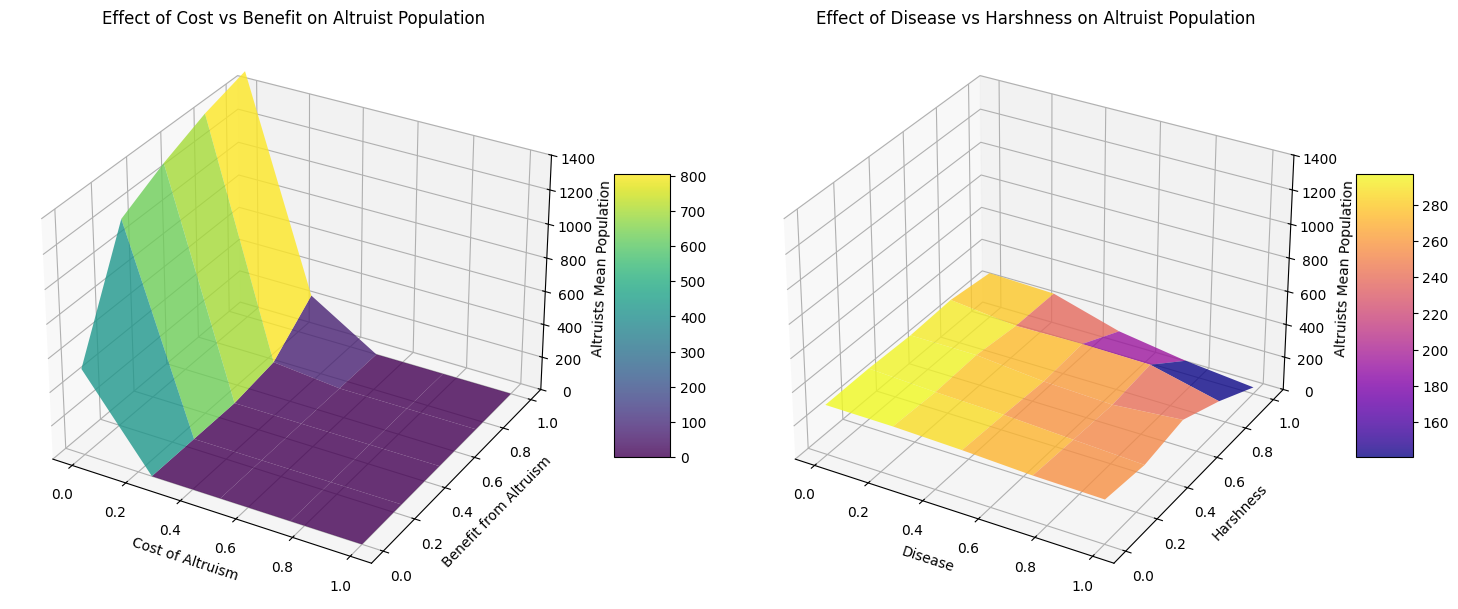

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# we already have these from above and can use them for plotting:
# Define the parameter ranges
cost_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
benefit_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
disease_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00
harshness_range = np.linspace(0, 1.0, 5)  # 0.00, 0.25, 0.50, 0.75, 1.00


# as mentioned in the markdown above, we coalesce (or aggregate, really) the relevant means into single node "steps" for each variable explored.
cost_benefit_z_df = df.groupby(['cost_of_altruism', 'benefit_from_altruism']).aggregate(
    altruists_mean=('altruists_mean', 'mean')  # mean of means... this will be our Z values
).reset_index()

# now we can greate a grid for the surface of the plot
# see: https://aleksandarhaber.com/explanation-of-pythons-meshgrid-function-numpy-and-3d-plotting-in-python/
X1, Y1 = np.meshgrid(cost_range, benefit_range)  

# print the values of X1 and Y1
# print(X1)
# print(Y1)  # looks good!

Z1 = np.zeros_like(X1)
for i, cost in enumerate(cost_range):
    for j, benefit in enumerate(benefit_range):
        intersection = df[(df['cost_of_altruism'] == cost) & (df['benefit_from_altruism'] == benefit)]
        if not intersection.empty:
            Z1[j, i] = intersection['altruists_mean'].mean()


# print(Z1)

# we have to use the exact same code (opposite params) for the other plot
disease_harshness_z_df = df.groupby(['disease', 'harshness']).aggregate(
    altruists_mean=('altruists_mean', 'mean')
).reset_index()

X2, Y2 = np.meshgrid(disease_range, harshness_range)

Z2 = np.zeros_like(X2)
for i, disease in enumerate(disease_range):
    for j, harshness in enumerate(harshness_range):
        intersection = df[(df['disease'] == disease) & (df['harshness'] == harshness)]
        if not intersection.empty:
            Z2[j, i] = intersection['altruists_mean'].mean()


# print(Z2)

fig = plt.figure(figsize=(15, 6))

# "We create the plot by calling the function “plot_surface(X, Y, Z, cmap=”plasma”, linewidth=0, antialiased=False, alpha=0.5):"
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X1, Y1, Z1, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('Cost of Altruism')
ax1.set_ylabel('Benefit from Altruism')
ax1.set_zlabel('Altruists Mean Population')
ax1.set_zlim(0,1400)
ax1.set_title('Effect of Cost vs Benefit on Altruist Population')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

# Second plot: Disease vs Harshness
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(X2, Y2, Z2, cmap='plasma', edgecolor='none', alpha=0.8)
ax2.set_xlabel('Disease')
ax2.set_ylabel('Harshness')
ax2.set_zlabel('Altruists Mean Population')
ax2.set_zlim(0,1400)
ax2.set_title('Effect of Disease vs Harshness on Altruist Population')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

These charts are somewhat as expected--of course, low costs of altruism and high benefit yield more altruists, though it would appear that the costs are more important. While all the values of altruism are low in our disease versus harshness plot, we might note that high degrees of each, as expected, cause a low number of altruists to last. This behavior is predicted by the model author. We might also observe a tiny bump on the plot, perhaps where we would expect it from manual operation of the model, at harshness and disease of 0.8. This is expected as some higher values of the pair do lead to more favorable conditions for altruism (as mentioned in the model notes.)

One possible next step would be more runs focused on that bump. From manual OAT probing on the modelʻs UI, that parameter "neighborhood" is very sensitive to change. It might also be noted that it seems that the other variables are somewhat "swamping" our Disease-Harshness view overall.

Now that we are at a point where we have some visibility to the system, we might switch over to the methods mentioned in Kwakkel (2017). That writeup indicates the use of of [SALib](https://salib.readthedocs.io/en/latest/) as a possibility for a similarly abstract model, and we should be able to adapt our data to work with the approach. We should be able to try both `altruists_mean` and `selfish_mean` as our currencies.

We will do most of the processing in our `pynetlogo_utils` module, but here, we can set up our problem and our (new) Sobel sampling pass, which will be more random.

In [3]:

altruism_problem = {
    'num_vars': 4,
    'names': ['cost_of_altruism', 'benefit_from_altruism', 'disease', 'harshness'],
    'bounds': [[0, 1], [0, 1], [0, .9], [0, .9]],  # we use the model caps here
    'outputs': ['pinks_count']
}

param_values = sobolsample.sample(altruism_problem, 1024, calc_second_order=True)

param_values.shape   # thatʻs a lot of runs!

(10240, 4)

In [4]:
max_ticks = 250  # way cheaper, though this isnʻt perfect. 
runs_per_node = 1  

# run the model with the new parameters
sobel_base_results_file = run_altruism_experiment_sobol(base_altruism_model, 
                                  "sobol_base", 
                                  max_ticks, 
                                  runs_per_node, 
                                  param_values,
                                  altruism_problem)

Created new results file: ./M4Model_Dresslar_base.nlogo_sobol_base_results.csv
Starting/Resuming Sobol experiment 'sobol_base'.
Total samples: 10240, Runs per sample: 1
Total runs required: 10240
Already completed (from checkpoint): 0
Running: Sample 1/10240, Rep 1/1 (Run 1/10240)



/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/pynetlogo/core.py:209: UserWarning: could not find default NetLogo extensions folder. Extensions not available
  warnings.warn(


Ran for ticks: 46.0 with 0.26 0.26 0.24762433022260666 0.3371467534452677 0.7979773010127247 0.5397031755186618
 Pops: [0.0] [874.0] [807.0]
Running: Sample 2/10240, Rep 1/1 (Run 2/10240)
Ran for ticks: 250.0 with 0.26 0.26 0.08853967022150755 0.3371467534452677 0.7979773010127247 0.5397031755186618
 Pops: [482.0] [549.0] [650.0]
Running: Sample 3/10240, Rep 1/1 (Run 3/10240)
Ran for ticks: 45.0 with 0.26 0.26 0.24762433022260666 0.2986885001882911 0.7979773010127247 0.5397031755186618
 Pops: [0.0] [924.0] [757.0]
Running: Sample 4/10240, Rep 1/1 (Run 4/10240)
Ran for ticks: 55.0 with 0.26 0.26 0.24762433022260666 0.3371467534452677 0.6077144273556769 0.5397031755186618
 Pops: [0.0] [1118.0] [563.0]
Running: Sample 5/10240, Rep 1/1 (Run 5/10240)
Ran for ticks: 58.0 with 0.26 0.26 0.24762433022260666 0.3371467534452677 0.7979773010127247 0.5254191627725959
 Pops: [0.0] [938.0] [743.0]
Running: Sample 6/10240, Rep 1/1 (Run 6/10240)
Ran for ticks: 65.0 with 0.26 0.26 0.24762433022260666 0

In [6]:
sobel_base_results_file = "sobol_base_results.csv"
results_df = pd.read_csv(sobel_base_results_file)

output_column_name = 'pinks_count'

if output_column_name not in results_df.columns:
    raise ValueError(f"Column '{output_column_name}' not found in the CSV file.")

expected_rows = 10240
if len(results_df) != expected_rows:
    raise ValueError(f"Expected {expected_rows} rows in CSV, but found {len(results_df)}.")   # for instance, we might not have actually finished the exp.

Y_altruists = results_df[output_column_name].to_numpy()  # ;;; OH MY GOD IF I USE SEMICOLON COMMENTS ONE MORE TIME. anyway, this shape is what SALib expects.

print(f"Shape of Y_altruists: {Y_altruists.shape}") # Should be (10240,)

Si_altruists = sobol.analyze(altruism_problem, Y_altruists, calc_second_order=True, print_to_console=True)
print(Si_altruists)

Shape of Y_altruists: (10240,)
                             ST   ST_conf
cost_of_altruism       0.939411  0.112649
benefit_from_altruism  0.354731  0.072998
disease                0.033140  0.014440
harshness              0.032970  0.014835
                             S1   S1_conf
cost_of_altruism       0.677826  0.127600
benefit_from_altruism  0.049545  0.049900
disease               -0.002206  0.013650
harshness             -0.002832  0.023016
                                                 S2   S2_conf
(cost_of_altruism, benefit_from_altruism)  0.238562  0.214490
(cost_of_altruism, disease)               -0.014209  0.196244
(cost_of_altruism, harshness)             -0.020811  0.192731
(benefit_from_altruism, disease)          -0.007279  0.067963
(benefit_from_altruism, harshness)         0.001469  0.061317
(disease, harshness)                       0.001105  0.019207
{'S1': array([ 0.67782619,  0.04954491, -0.00220617, -0.00283176]), 'S1_conf': array([0.12759975, 0.0499    , 0.013

/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

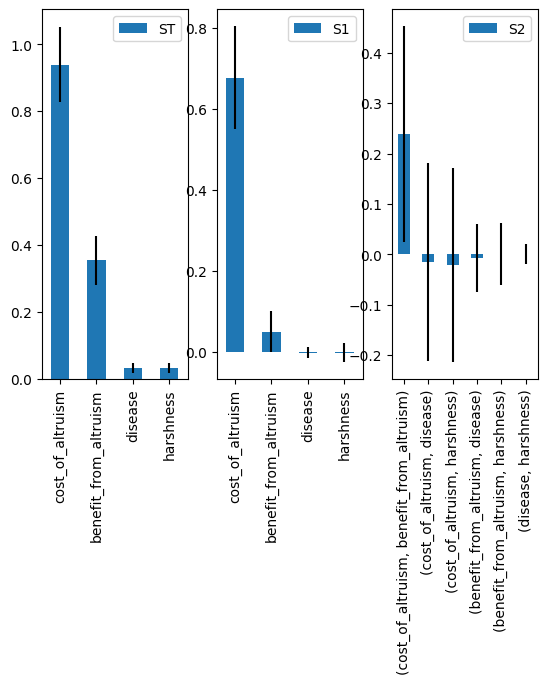

In [7]:
Si_altruists.plot()

As we can see, the model is quite sensitive in particular to `cost_of_altruism`, and to a lesser degree `benefit_of_altruism`, *with respect to our altruism currency*. Since we are looking specifically at altruist outcomes, this result seems acceptable. We might also note the second order effects between `cost` and `benefit`. 

Now, we can also look at the sensitivity analysis for the Selfish group, our "greens" from the model.

In [8]:
other_output_column_name = 'greens_count'

Y_selfish = results_df[other_output_column_name].to_numpy()
Si_selfish = sobol.analyze(altruism_problem, Y_selfish, calc_second_order=True, print_to_console=True)
print(Si_selfish)


                             ST   ST_conf
cost_of_altruism       0.502167  0.070503
benefit_from_altruism  0.187897  0.042959
disease                0.222027  0.030328
harshness              0.398695  0.053070
                             S1   S1_conf
cost_of_altruism       0.314392  0.078683
benefit_from_altruism  0.006845  0.039906
disease                0.143173  0.043651
harshness              0.316850  0.060491
                                                 S2   S2_conf
(cost_of_altruism, benefit_from_altruism)  0.123969  0.093413
(cost_of_altruism, disease)                0.003700  0.094019
(cost_of_altruism, harshness)              0.002925  0.097413
(benefit_from_altruism, disease)           0.009181  0.046670
(benefit_from_altruism, harshness)         0.012562  0.045675
(disease, harshness)                       0.034981  0.062390
{'S1': array([0.31439187, 0.00684458, 0.14317269, 0.31685044]), 'S1_conf': array([0.0786831 , 0.03990589, 0.04365075, 0.06049096]), 'ST': array([0

/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


SALib comes with some pretty terrific (from this perspective, anyway) built-in plotting functions out of the box:

/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

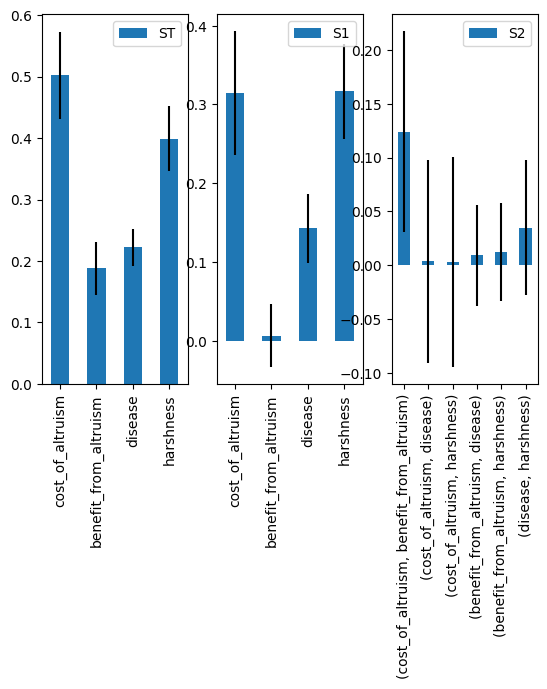

In [9]:
Si_selfish.plot()

This is also an interesting outcome, in particular due to the fact that we know that `disease` and `harshness` have a strong contol on "perishment" of selfish from our OAT testing (and our general noodling with the model via the UI).

Next, we can develop a plot using code straight from the `pynetlogo` documentation to explore second order effects in particular. This code is lifted almost one-for-one from the example, which is a real credit to the setup of SALib! We have our object setup and now we can do some very fun analysis.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
import itertools
from math import pi



def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw, zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc == "w":
            fill = False
        else:
            ec = "none"

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle(
            (x, y),
            radius=si,
            ec=ec,
            fc=fc,
            transform=ax.transData._b,
            zorder=zorder,
            lw=lw,
            fill=True,
        )
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ["ST", "S1", "S2"]:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten()  # flatten in case of S2
        # TODO:: remove nans

        filtered = [(name, locs[i]) for i, name in enumerate(names) if data[i] > threshold]
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ["ST_conf", "S1_conf", "S2_conf"]:
        raise NotImplementedError
    else:
        raise ValueError("unknown value for criterion")

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, this_altruism_problem, criterion="ST", threshold=0.01):
    """plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    """
    max_linewidth_s2 = 15  # 25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key: sobol_indices[key] for key in ["ST", "S1"]}
    sobol_stats = pd.DataFrame(sobol_stats, index=this_altruism_problem["names"])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices["S2"], index=this_altruism_problem["names"], columns=this_altruism_problem["names"])
    s2[s2 < 0.0] = 0.0  # Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = this_altruism_problem["names"]
    n = len(names)
    ticklocs = np.linspace(0, 2 * pi, n + 1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs, criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines["polar"].set_visible(False)

    ax.set_xticks(locs)
    ax.set_xticklabels(names)

    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(
        ax,
        filtered_locs,
        filtered_names,
        max_s_radius,
        sobol_stats["ST"],
        smax,
        smin,
        "w",
        "k",
        1,
        9,
    )

    # plot S1
    plot_circles(
        ax,
        filtered_locs,
        filtered_names,
        max_s_radius,
        sobol_stats["S1"],
        smax,
        smin,
        "k",
        "k",
        1,
        10,
    )

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5 + max_linewidth_s2 * normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1, 1], c="darkgray", lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch


class HandlerCircle(HandlerPatch):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


def legend(ax):
    some_identifiers = [
        plt.Circle((0, 0), radius=5, color="k", fill=False, lw=1),
        plt.Circle((0, 0), radius=5, color="k", fill=True),
        plt.Line2D([0, 0.5], [0, 0.5], lw=8, color="darkgray"),
    ]
    ax.legend(
        some_identifiers,
        ["ST", "S1", "S2"],
        loc=(1, 0.75),
        borderaxespad=0.1,
        mode="expand",
        handler_map={plt.Circle: HandlerCircle()},
    )



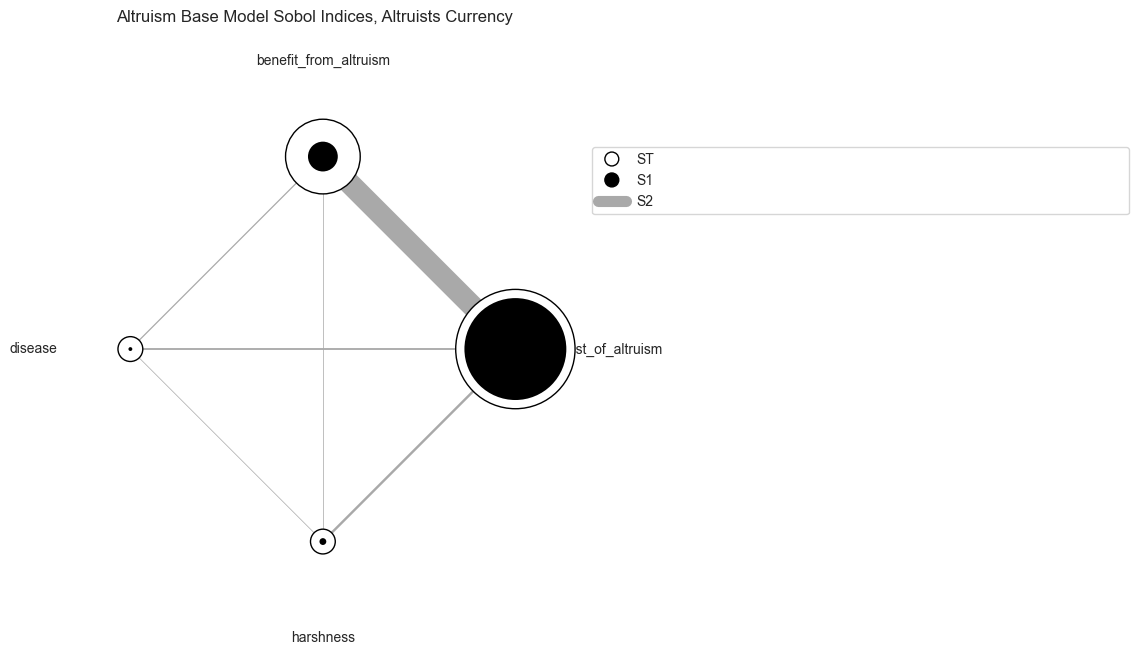

In [11]:
sns.set_style("whitegrid")
fig = plot_sobol_indices(Si_altruists, altruism_problem, criterion="ST", threshold=0.005)
fig.suptitle("Altruism Base Model Sobol Indices, Altruists Currency")
fig.set_size_inches(7, 7)
plt.show()

These plots do a terrific job of communicating both the first and second order sensitivity effects of the controls on the model. The thickness of the grey line between them indicates the strength of the second order effect between parameters. Again we see our relationship from `cost` to `benefit`.

Next, we can run the same plot for our selfish outcomes as currency:

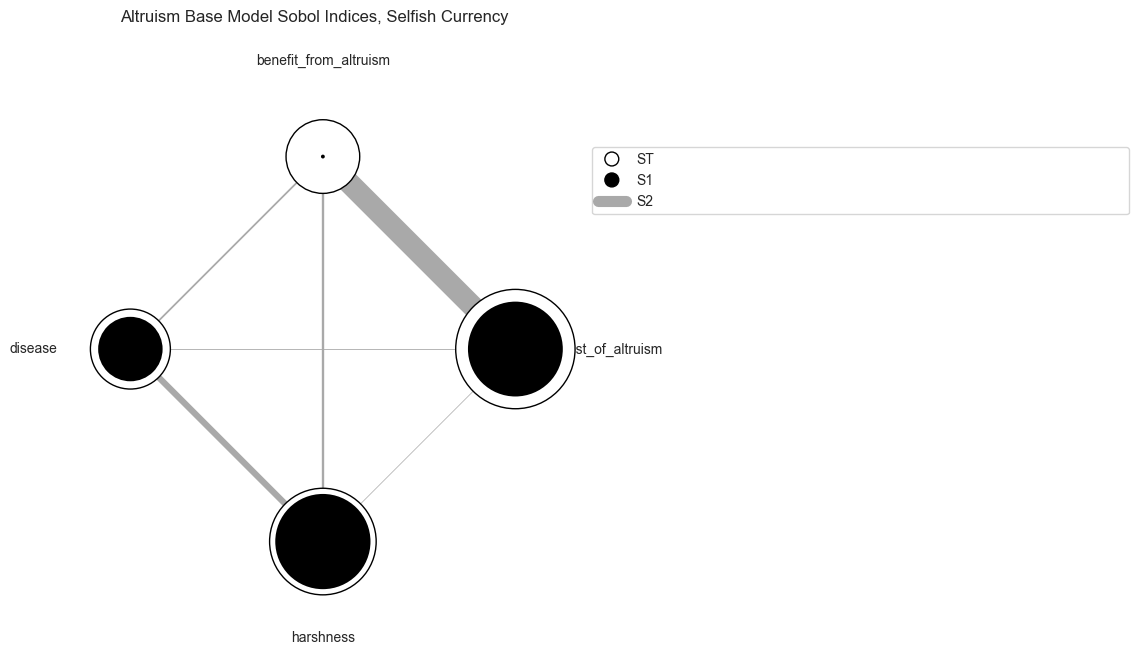

In [12]:
sns.set_style("whitegrid")
fig = plot_sobol_indices(Si_selfish, altruism_problem, criterion="ST", threshold=0.005)
fig.suptitle("Altruism Base Model Sobol Indices, Selfish Currency")
fig.set_size_inches(7, 7)
plt.show()

It would merit further exploration--exploration that I will here declare outside the scope of weekly homework--to investigate the confluence of first and second order sensititivity *across* the two currencies, though through the visualizations we already have, it seems that we have a fairly good feel for where we are already.

### Alternate Model

Finally, since we have the setup all ready, we might as well take a look at our "less stochastic" alternate model from the first part of the assignment.

In [13]:
alt_altruism_problem = {
    'num_vars': 4,
    'names': ['cost_of_altruism', 'benefit_from_altruism', 'disease', 'harshness'],
    'bounds': [[0, 1], [0, 1], [0, .9], [0, .9]],  # we use the model caps here
    'outputs': ['pinks_count']
}

param_values = sobolsample.sample(alt_altruism_problem, 1024, calc_second_order=True)

In [14]:
max_ticks = 250  # way cheaper, though this isnʻt perfect. 
runs_per_node = 1  

# run the model with the new parameters
sobel_base_results_file = run_altruism_experiment_sobol(alt_altruism_model, 
                                  "sobol_alt", 
                                  max_ticks, 
                                  runs_per_node, 
                                  param_values,
                                  alt_altruism_problem)

Created new results file: ./M4Model_Dresslar_modified.nlogo_sobol_alt_results.csv
Starting/Resuming Sobol experiment 'sobol_alt'.
Total samples: 10240, Runs per sample: 1
Total runs required: 10240
Already completed (from checkpoint): 0
Running: Sample 1/10240, Rep 1/1 (Run 1/10240)


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/pynetlogo/core.py:209: UserWarning: could not find default NetLogo extensions folder. Extensions not available
  warnings.warn(


Ran for ticks: 4.0 with 0.26 0.26 0.8913788804784417 0.1403623316437006 0.7098581786267459 0.4573080766014755
 Pops: [0.0] [828.0] [853.0]
Running: Sample 2/10240, Rep 1/1 (Run 2/10240)
Ran for ticks: 24.0 with 0.26 0.26 0.43267021980136633 0.1403623316437006 0.7098581786267459 0.4573080766014755
 Pops: [0.0] [1103.0] [578.0]
Running: Sample 3/10240, Rep 1/1 (Run 3/10240)
Ran for ticks: 12.0 with 0.26 0.26 0.8913788804784417 0.755306645296514 0.7098581786267459 0.4573080766014755
 Pops: [0.0] [1086.0] [595.0]
Running: Sample 4/10240, Rep 1/1 (Run 4/10240)
Ran for ticks: 5.0 with 0.26 0.26 0.8913788804784417 0.1403623316437006 0.1544841567054391 0.4573080766014755
 Pops: [0.0] [1355.0] [326.0]
Running: Sample 5/10240, Rep 1/1 (Run 5/10240)
Ran for ticks: 6.0 with 0.26 0.26 0.8913788804784417 0.1403623316437006 0.7098581786267459 0.1973611017689109
 Pops: [0.0] [1308.0] [373.0]
Running: Sample 6/10240, Rep 1/1 (Run 6/10240)
Ran for ticks: 10.0 with 0.26 0.26 0.8913788804784417 0.75530664

We can now run our analyses just as we did for our "base" experiment using the stock Altruism model.

In [20]:
sobel_alt_results_file = "sobol_alt_results.csv"
results_df = pd.read_csv(sobel_alt_results_file)

output_column_name = 'pinks_count'

if output_column_name not in results_df.columns:
    raise ValueError(f"Column '{output_column_name}' not found in the CSV file.")
expected_rows = 10240
if len(results_df) != expected_rows:
    raise ValueError(f"Expected {expected_rows} rows in CSV, but found {len(results_df)}.")
Y_altruists = results_df[output_column_name].to_numpy()
print(f"Shape of Y_altruists: {Y_altruists.shape}") # (10240,)
Si_alt_altruists = sobol.analyze(alt_altruism_problem, Y_altruists, calc_second_order=True, print_to_console=True)

print(Si_alt_altruists)

Shape of Y_altruists: (10240,)
                             ST   ST_conf
cost_of_altruism       0.936228  0.094015
benefit_from_altruism  0.313927  0.065664
disease                0.025998  0.010288
harshness              0.033088  0.014789
                             S1   S1_conf
cost_of_altruism       0.633166  0.103457
benefit_from_altruism  0.041126  0.057439
disease                0.005634  0.015313
harshness             -0.001796  0.014824
                                                 S2   S2_conf
(cost_of_altruism, benefit_from_altruism)  0.276354  0.213377
(cost_of_altruism, disease)                0.023175  0.183518
(cost_of_altruism, harshness)              0.033276  0.183920
(benefit_from_altruism, disease)          -0.012885  0.071021
(benefit_from_altruism, harshness)        -0.000282  0.069828
(disease, harshness)                      -0.010550  0.018350
{'S1': array([ 0.63316606,  0.04112582,  0.00563385, -0.00179639]), 'S1_conf': array([0.10345719, 0.05743877, 0.015

/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

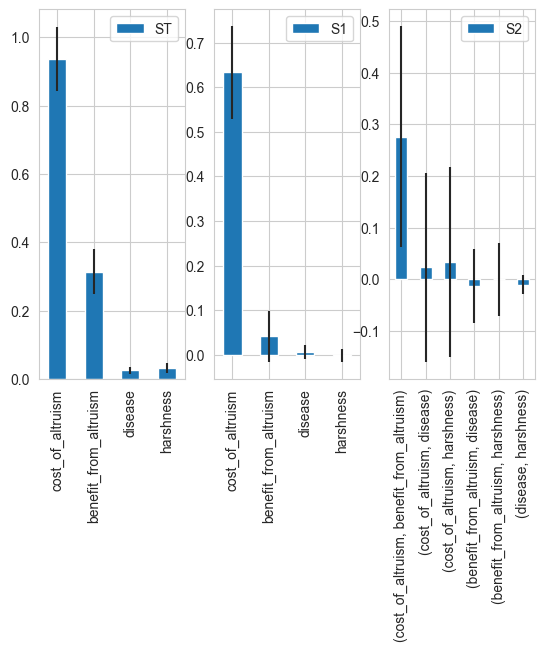

In [21]:
Si_alt_altruists.plot()

...and then "greens,"

/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                             ST   ST_conf
cost_of_altruism       0.492390  0.059987
benefit_from_altruism  0.159880  0.041888
disease                0.217973  0.029556
harshness              0.391043  0.041203
                             S1   S1_conf
cost_of_altruism       0.301026  0.077177
benefit_from_altruism  0.002082  0.038268
disease                0.146656  0.038217
harshness              0.308550  0.057559
                                                 S2   S2_conf
(cost_of_altruism, benefit_from_altruism)  0.131516  0.105295
(cost_of_altruism, disease)                0.008706  0.105707
(cost_of_altruism, harshness)              0.012482  0.098013
(benefit_from_altruism, disease)           0.011398  0.051116
(benefit_from_altruism, harshness)        -0.002871  0.051822
(disease, harshness)                       0.027080  0.059735


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

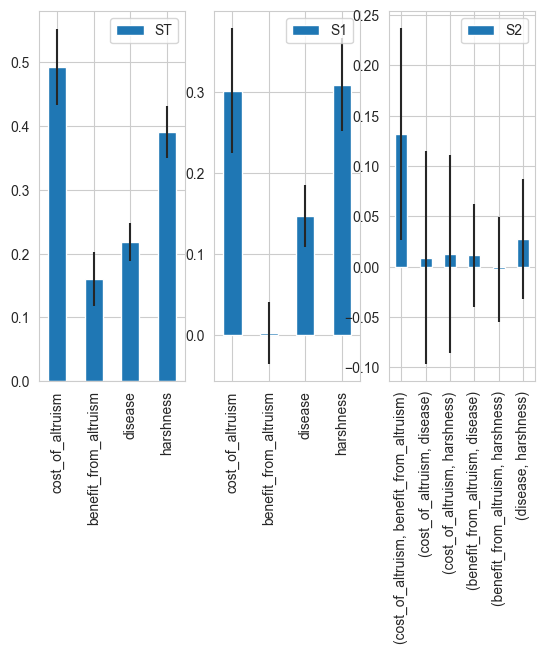

In [22]:
other_alt_output_column_name = 'greens_count'

Y_selfish = results_df[other_alt_output_column_name].to_numpy()
Si_alt_selfish = sobol.analyze(alt_altruism_problem, Y_selfish, calc_second_order=True, print_to_console=True)
Si_alt_selfish.plot()

And then our 2nd order plots would be:

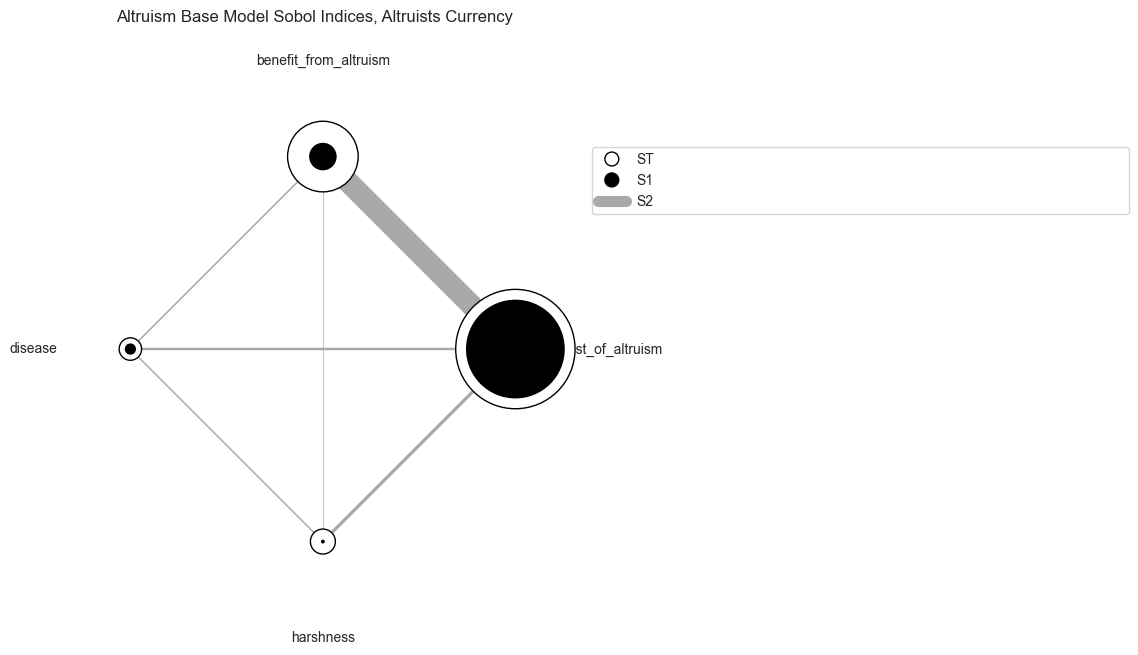

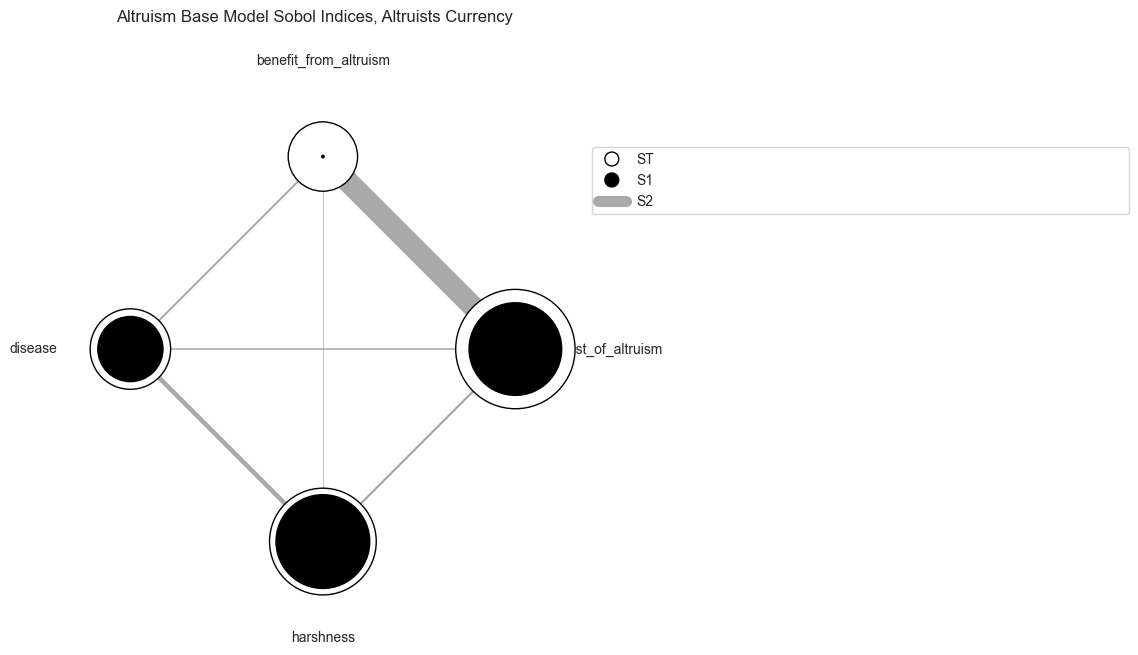

In [23]:
sns.set_style("whitegrid")
fig = plot_sobol_indices(Si_alt_altruists, alt_altruism_problem, criterion="ST", threshold=0.005)
fig.suptitle("Altruism Base Model Sobol Indices, Altruists Currency")
fig.set_size_inches(7, 7)
plt.show()

sns.set_style("whitegrid")
fig = plot_sobol_indices(Si_alt_selfish, alt_altruism_problem, criterion="ST", threshold=0.005)
fig.suptitle("Altruism Base Model Sobol Indices, Altruists Currency")
fig.set_size_inches(7, 7)
plt.show()

I had hoped to see a bit more change in sensititivies, especially on the 2nd order, for our "less-stochastic" version of the model, but the results seem less than conclusive. And, with that, if you have read this far, dear reader, I suspect you will join me in agreeing that this should conclude this chapter of our exploration of parameter sensitivity in NetLogoʻs Altruism.

### Notes

### References

[1] Kwakkel, J. H., & Jaxa-Rozen, M. (2017). Example 2: Sensitivity analysis for a NetLogo model with SALib and ipyparallel. pyNetLogo Documentation. https://pynetlogo.readthedocs.io/en/latest/docs/SALib_ipyparallel.html

[2] Ligmann-Zielinska, A., Siebers, P. O., Magliocca, N., Parker, D. C., Grimm, V., Du, J., ... & Ye, X. (2020). ‘One size does not fit all’: A roadmap of purpose-driven mixed-method pathways for sensitivity analysis of agent-based models. Journal of Artificial Societies and Social Simulation, 23(1).